## Import Batman

In [1]:
from batman import TransitModel, TransitParams
from batman.openmp import detect
import timeit
import numpy as np
import matplotlib.pyplot as plt

from batman import _nonlinear_ld
from batman import _quadratic_ld
from batman import _uniform_ld
from batman import _logarithmic_ld
from batman import _exponential_ld
from batman import _power2_ld
from batman import _custom_ld
from batman import _rsky
from batman import _eclipse
from math import pi
import multiprocessing
from batman import openmp

## Below is an example of a simulated exoplanet transit light curve we produced using batman:

### This was just to get a sense for how to generate a transit light curve and what it would look like. Our parameter choices were arbitrary.

Text(0.5, 1.0, 'Simulated Transit Light Curve')

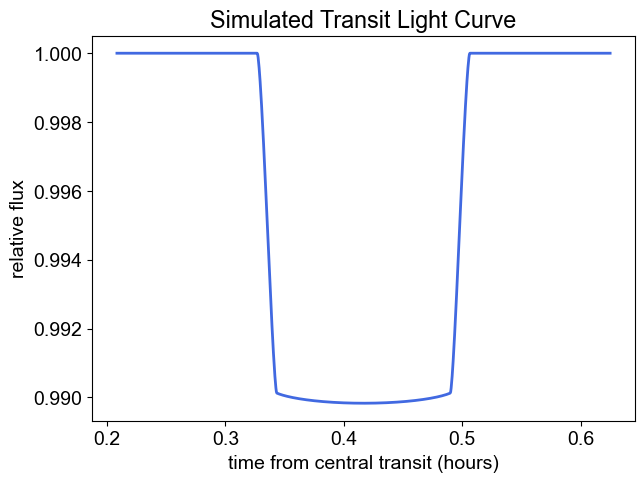

In [6]:
import batman
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from matplotlib import rc

rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
matplotlib.rcParams.update({'font.size':14})

M_s = 1.9885*1e30
m_p = M_s * 0.001
G = 6.67 * 1e-11
T = 10 * (24*60*60)
a = (G*(M_s+m_p)*T**2/(4*np.pi**2))**(1/3)
R_s = 6.96e8  # Stellar radius in meters
a = a / R_s  # Convert semi-major axis to stellar radii

params = batman.TransitParams()         #object to store transit parameters
params.t0 = 10/24.             # mid transit point
params.per = 10.             #orbital period
params.rp = 0.1             #planet radius (in units of stellar radii)
params.a = a              #semi-major axis (in units of stellar radii)
params.inc = 90            #orbital inclination (in degrees)
params.ecc = 0.             #eccentricity
params.w = 90.              #longitude of periastron (in degrees)
params.limb_dark = "quadratic"          #limb darkening model
params.u = [.05,0]        #limb darkening coefficients
   
#t = np.linspace(-0.025, 0.025, 1000)   #times at which to calculate light curve	
t = np.loadtxt('times.txt')
t = t[0]/24
#t = np.linspace(-.25, .25, 1000)

m = batman.TransitModel(params, t)      #initializes model

flux = m.light_curve(params)       #calculates light curve

fig, ax = plt.subplots(figsize=[7, 5])
ax.plot(t, flux,color='royalblue',lw=2, label="Transit light curve")
ax.set_xlabel('time from central transit (hours)')
ax.set_ylabel('relative flux')
ax.set_title('Simulated Transit Light Curve')
#m = batman.TransitModel(params, t, supersample_factor = 7, exp_time = 0.001)

# Part I: MCMC modelling of the single planet transit

### Below is the mcmc code that we wrote to find the best-fit parameters for the transit of a single planet around its host star. The explanation of our methods and analysis of the results can be found in the overleaf file within our final project folder.

In [56]:
import corner
import batman as bm
import numpy as np
from matplotlib import pyplot as plt
import time
import matplotlib as mpl
from tqdm import trange
mpl.rcParams['figure.dpi'] = 300

global ld_type
ld_type = 'quadratic'

global inc
global ecc
global w

global P
P = 10


inc = 90
ecc = 0.0
w = 90

np.random.seed(42)


def get_transit(pars, t):
    pars = np.array(pars, dtype=float)
    params = bm.TransitParams()  # object to store transit parameters
    params.t0 = pars[0]  # mid-transit point
    params.per = P  # orbital period
    params.rp = pars[1]  # planet radius (in units of stellar radii)
    params.a = pars[2]  # semi-major axis (in units of stellar radii)
    params.inc = inc  # orbital inclination (in degrees)
    params.ecc = ecc  # eccentricity
    params.w = w  # longitude of periastron (in degrees)
    params.u = pars[3:5]  # limb darkening coefficients
    params.limb_dark = ld_type  # limb darkening model

    model = bm.TransitModel(params, t)  # initializes model
    light_curve = model.light_curve(params)  # calculates light curve

    return light_curve


def chisq(pars, data, t, Ninv):
    if pars[3]<0 or pars[4]<0:
        return np.inf
    else: 
        y = get_transit(pars, t)
        r = data-y
        chisq = r@Ninv@r
        return chisq


def run_chain(pars, fun, data, t, Ninv, L, nsamp=100, adapt_steps=10, target_acceptance=0.45):
    chisq = np.zeros(nsamp)
    npar = len(pars)
    chain = np.zeros([nsamp, npar])
    chain[0, :] = pars
    chisq[0] = fun(pars, data, t, Ninv)
    acceptance_count = 0  # Track acceptance count
    step_size = L  # Initialize step size

    for i in trange(1, nsamp):
        pnew = chain[i - 1, :] + step_size * np.random.randn(npar)
        chi_new = fun(pnew, data, t, Ninv)
        prob = np.exp(0.5 * (chisq[i - 1] - chi_new))

        if np.random.rand() < prob:  # Accept step
            chain[i, :] = pnew
            chisq[i] = chi_new
            acceptance_count += 1
        else:  # Reject step
            chain[i, :] = chain[i - 1, :]
            chisq[i] = chisq[i - 1]

#         # Adjust step size every `adapt_steps` iterations
        if i % adapt_steps == 0:
            acceptance_rate = acceptance_count / adapt_steps
            #print(acceptance_rate)
            if acceptance_rate < target_acceptance:
                step_size *= 0.5  # Decrease step size
            elif acceptance_rate > target_acceptance:
                step_size *= 1.5  # Increase step size
            acceptance_count = 0  # Reset acceptance count

    return chain, chisq


t = np.loadtxt('times.txt')
t = t[0] / 24
lc_observed = np.loadtxt('lightcurve.txt')
flux = lc_observed[0]
errs = np.zeros(len(flux))+1.6e-3

# set initial parameters
titles = ['T0', 'Rp/Rs',
          'a/Rs',  'u1', 'u2']
real = np.asarray([10/24,  0.1, 19.5177,  0.4, 0.1])
pguess = np.asarray([0.4,  0.08, 10,  0.0, 0.0])  # input

# L = pguess*[1e-2, 1e-2, 1e-2, 1e-3, 1e-3]
L = pguess*5e-3
L[-2] = 0.001
L[-1] = 0.001
# L = np.array([0.005, 0.05, 0.005, 0.005, 0.05, 0.001, 0.05, 0.005, 0.005])*1e-1


Ninv = np.diag(1/errs**2)

# %%
file = False
nsamp = 40000
burnin = 10000
if file:
    chain = np.genfromtxt('chains.txt')
    chainvec = np.genfromtxt('chis.txt')

else:

    chain, chivec = run_chain(pguess, chisq, flux, t, Ninv,
                              L=L, nsamp=nsamp)
    chain = chain[burnin:, :]
    chivec = chivec[burnin:]
    np.savetxt('chains.txt', chain)
    np.savetxt('chis.txt', chivec)

# %%


steps = np.arange(0, nsamp)
steps = steps[burnin:]
# Number of parameters
n_params = len(titles)


100%|███████████████████████████████████| 39999/39999 [00:14<00:00, 2733.10it/s]


### Trace plots for each parameter to check for convergence:

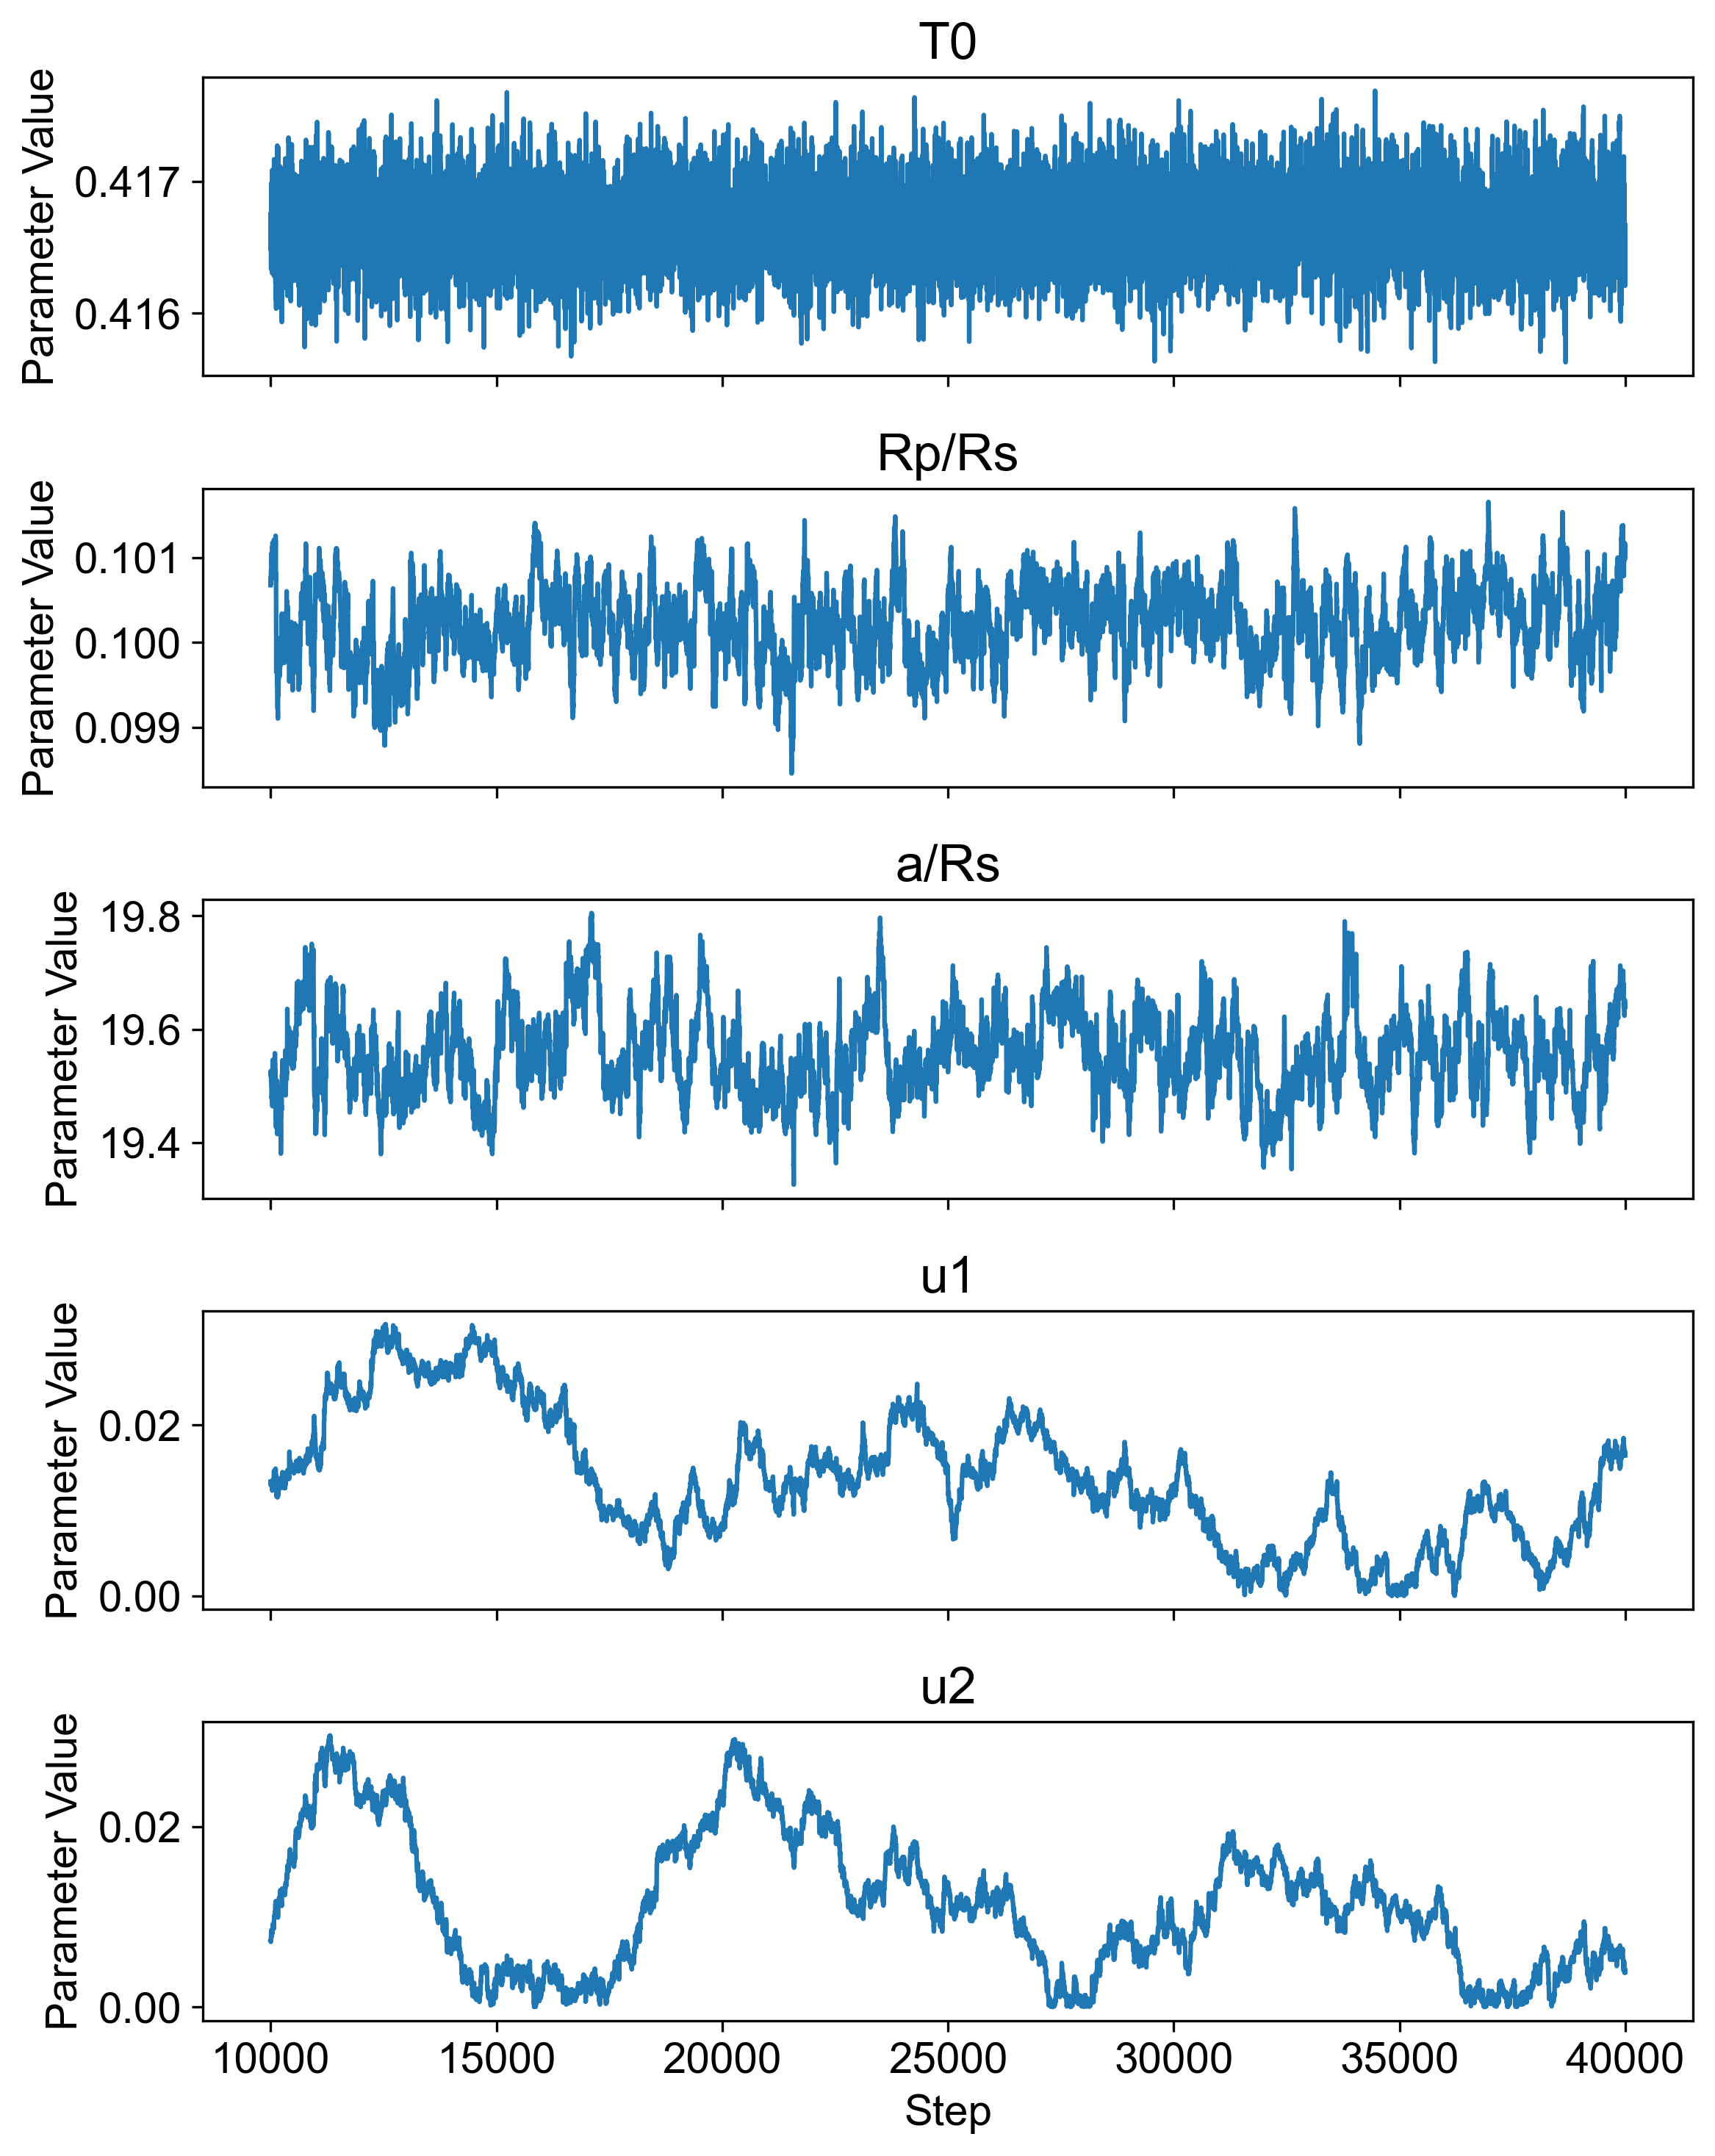

In [57]:
# Create a figure and subplots stacked vertically
fig, axes = plt.subplots(n_params, 1, figsize=(8, 2 * n_params), sharex=True)

# Plot each parameter chain on its corresponding subplot
for i, ax in enumerate(axes):
    ax.plot(steps, chain[:, i])  # Plot for the i-th parameter
    ax.set_title(titles[i])
    ax.set_ylabel("Parameter Value")

# Label the x-axis only on the bottom plot
axes[-1].set_xlabel("Step")

# Adjust the layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()


### Corner plots to check covariances between parameters:

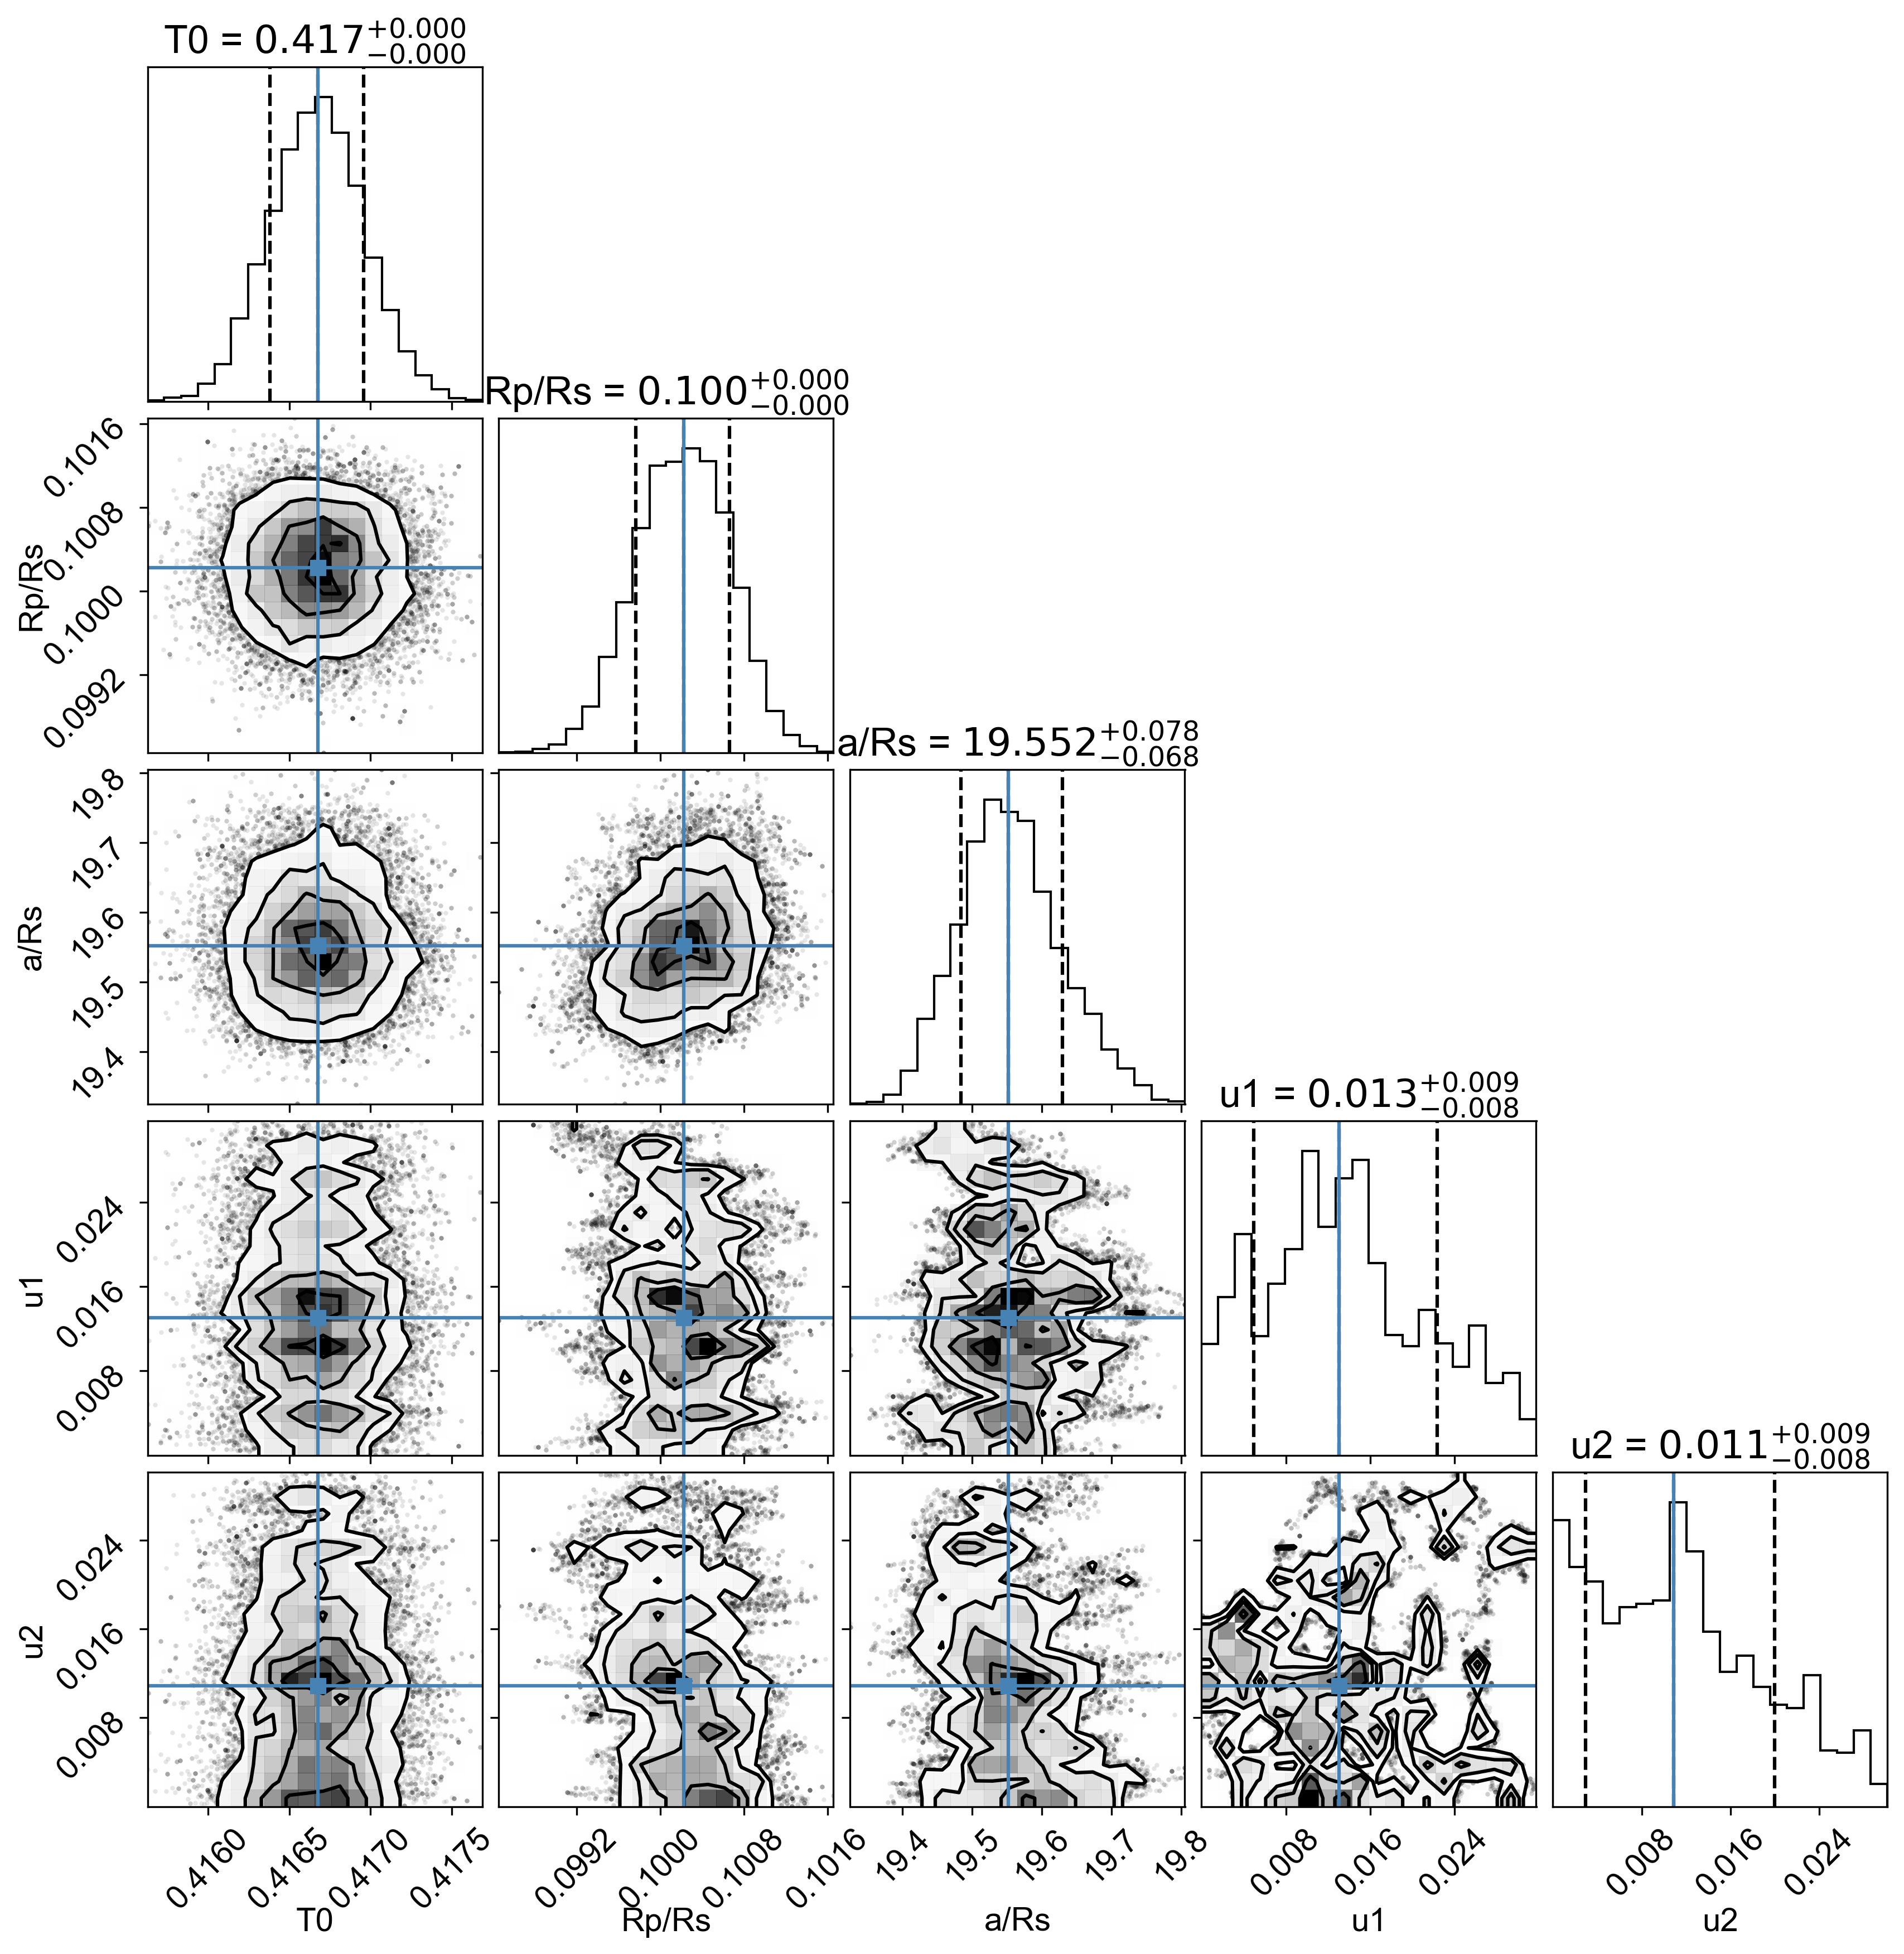

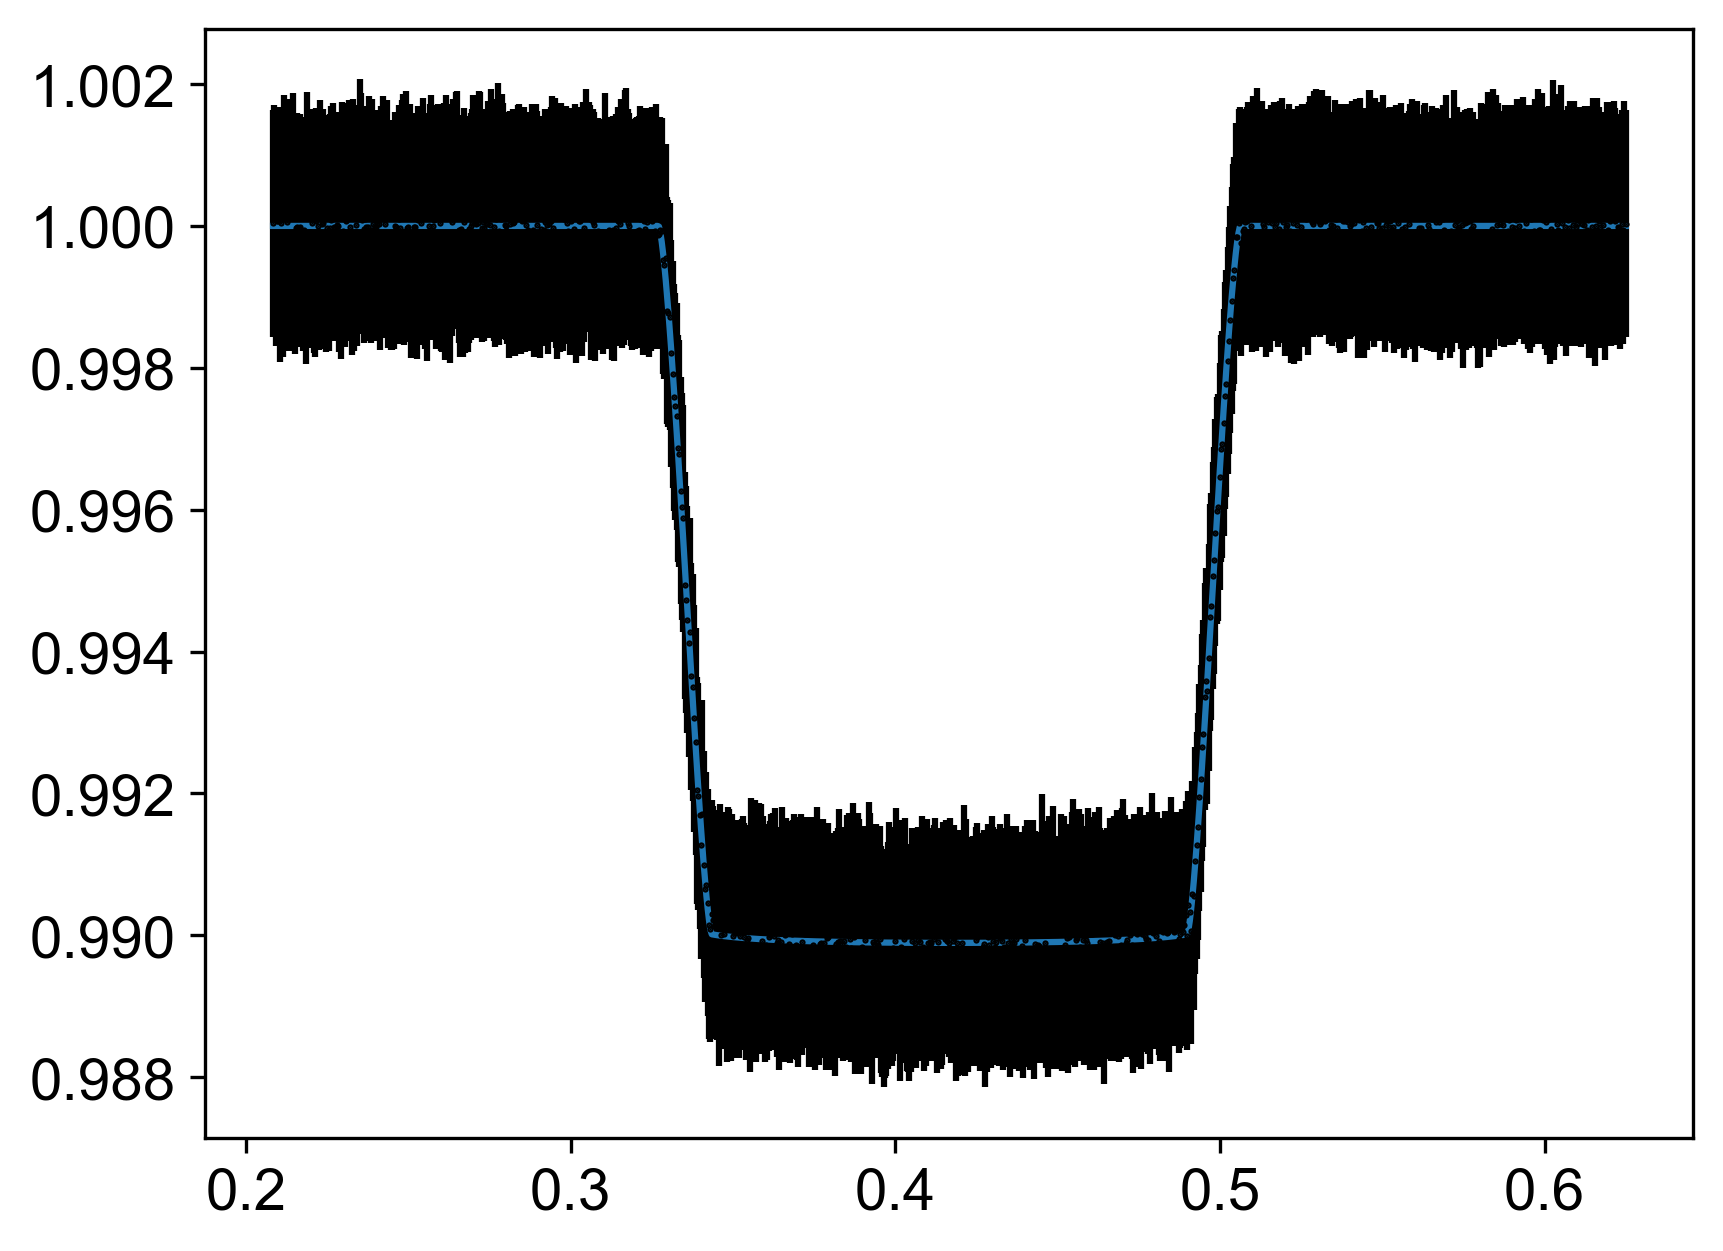

In [58]:
# Create a corner plot
fig = corner.corner(chain, labels=titles, truths=np.median(
    chain, axis=0), quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='.3f', )

# Show the plot
plt.show()

plt.errorbar(t, flux, errs, fmt='.', c='k', markersize=1)
plt.plot(t, get_transit(np.mean(chain, axis=0), t))
plt.show()

### Comparison between true parameters and best-fit parameters:

In [59]:
print("The true parameters are",real)
print('\n')
print("The best-fit parameters are",np.mean(chain, axis=0))

The true parameters are [ 0.41666667  0.1        19.5177      0.4         0.1       ]


The best-fit parameters are [4.16673306e-01 1.00212516e-01 1.95561864e+01 1.36829362e-02
 1.14049234e-02]


### Here are the results when we run mcmc while fixing the limb darkening coefficients

In [60]:
import corner
import batman as bm
import numpy as np
from matplotlib import pyplot as plt
import time
import matplotlib as mpl
from tqdm import trange
mpl.rcParams['figure.dpi'] = 300

global ld_type
ld_type = 'quadratic'

global inc
global ecc
global w
global u1
global u2

global P
P = 10


inc = 90
ecc = 0.0
w = 90
u1 = 0.4
u2 = 0.1

np.random.seed(42)


def get_transit(pars, t):
    pars = np.array(pars, dtype=float)
    params = bm.TransitParams()  # object to store transit parameters
    params.t0 = pars[0]  # mid-transit point
    params.per = P  # orbital period
    params.rp = pars[1]  # planet radius (in units of stellar radii)
    params.a = pars[2]  # semi-major axis (in units of stellar radii)
    params.inc = inc  # orbital inclination (in degrees)
    params.ecc = ecc  # eccentricity
    params.w = w  # longitude of periastron (in degrees)
    params.u = [u1,u2]  # limb darkening coefficients
    params.limb_dark = ld_type  # limb darkening model

    model = bm.TransitModel(params, t)  # initializes model
    light_curve = model.light_curve(params)  # calculates light curve

    return light_curve


def chisq(pars, data, t, Ninv):
    y = get_transit(pars, t)
    r = data-y
    chisq = r@Ninv@r
    return chisq


def run_chain(pars, fun, data, t, Ninv, L, nsamp=100, adapt_steps=10, target_acceptance=0.45):
    chisq = np.zeros(nsamp)
    npar = len(pars)
    chain = np.zeros([nsamp, npar])
    chain[0, :] = pars
    chisq[0] = fun(pars, data, t, Ninv)
    acceptance_count = 0  # Track acceptance count
    step_size = L  # Initialize step size

    for i in trange(1, nsamp):
        pnew = chain[i - 1, :] + step_size * np.random.randn(npar)
        chi_new = fun(pnew, data, t, Ninv)
        prob = np.exp(0.5 * (chisq[i - 1] - chi_new))

        if np.random.rand() < prob:  # Accept step
            chain[i, :] = pnew
            chisq[i] = chi_new
            acceptance_count += 1
        else:  # Reject step
            chain[i, :] = chain[i - 1, :]
            chisq[i] = chisq[i - 1]

#         # Adjust step size every `adapt_steps` iterations
        if i % adapt_steps == 0:
            acceptance_rate = acceptance_count / adapt_steps
            #print(acceptance_rate)
            if acceptance_rate < target_acceptance:
                step_size *= 0.5  # Decrease step size
            elif acceptance_rate > target_acceptance:
                step_size *= 1.5  # Increase step size
            acceptance_count = 0  # Reset acceptance count

    return chain, chisq


t = np.loadtxt('times.txt')
t = t[0] / 24
lc_observed = np.loadtxt('lightcurve.txt')
flux = lc_observed[0]
errs = np.zeros(len(flux))+1.6e-3

# set initial parameters
titles = ['T0', 'Rp/Rs',
          'a/Rs']
real = np.asarray([10/24,  0.1, 19.5177])
pguess = np.asarray([0.4,  0.08, 10])  # input

# L = pguess*[1e-2, 1e-2, 1e-2, 1e-3, 1e-3]
L = pguess*1e-3
#L[-2] = 0.001
#L[-1] = 0.001
# L = np.array([0.005, 0.05, 0.005, 0.005, 0.05, 0.001, 0.05, 0.005, 0.005])*1e-1


Ninv = np.diag(1/errs**2)

# %%
file = False
nsamp = 40000
burnin = 10000
if file:
    chain = np.genfromtxt('chains.txt')
    chainvec = np.genfromtxt('chis.txt')

else:

    chain, chivec = run_chain(pguess, chisq, flux, t, Ninv,
                              L=L, nsamp=nsamp)
    chain = chain[burnin:, :]
    chivec = chivec[burnin:]
    np.savetxt('chains.txt', chain)
    np.savetxt('chis.txt', chivec)

# %%


steps = np.arange(0, nsamp)
steps = steps[burnin:]
# Number of parameters
n_params = len(titles)


100%|███████████████████████████████████| 39999/39999 [00:09<00:00, 4021.66it/s]


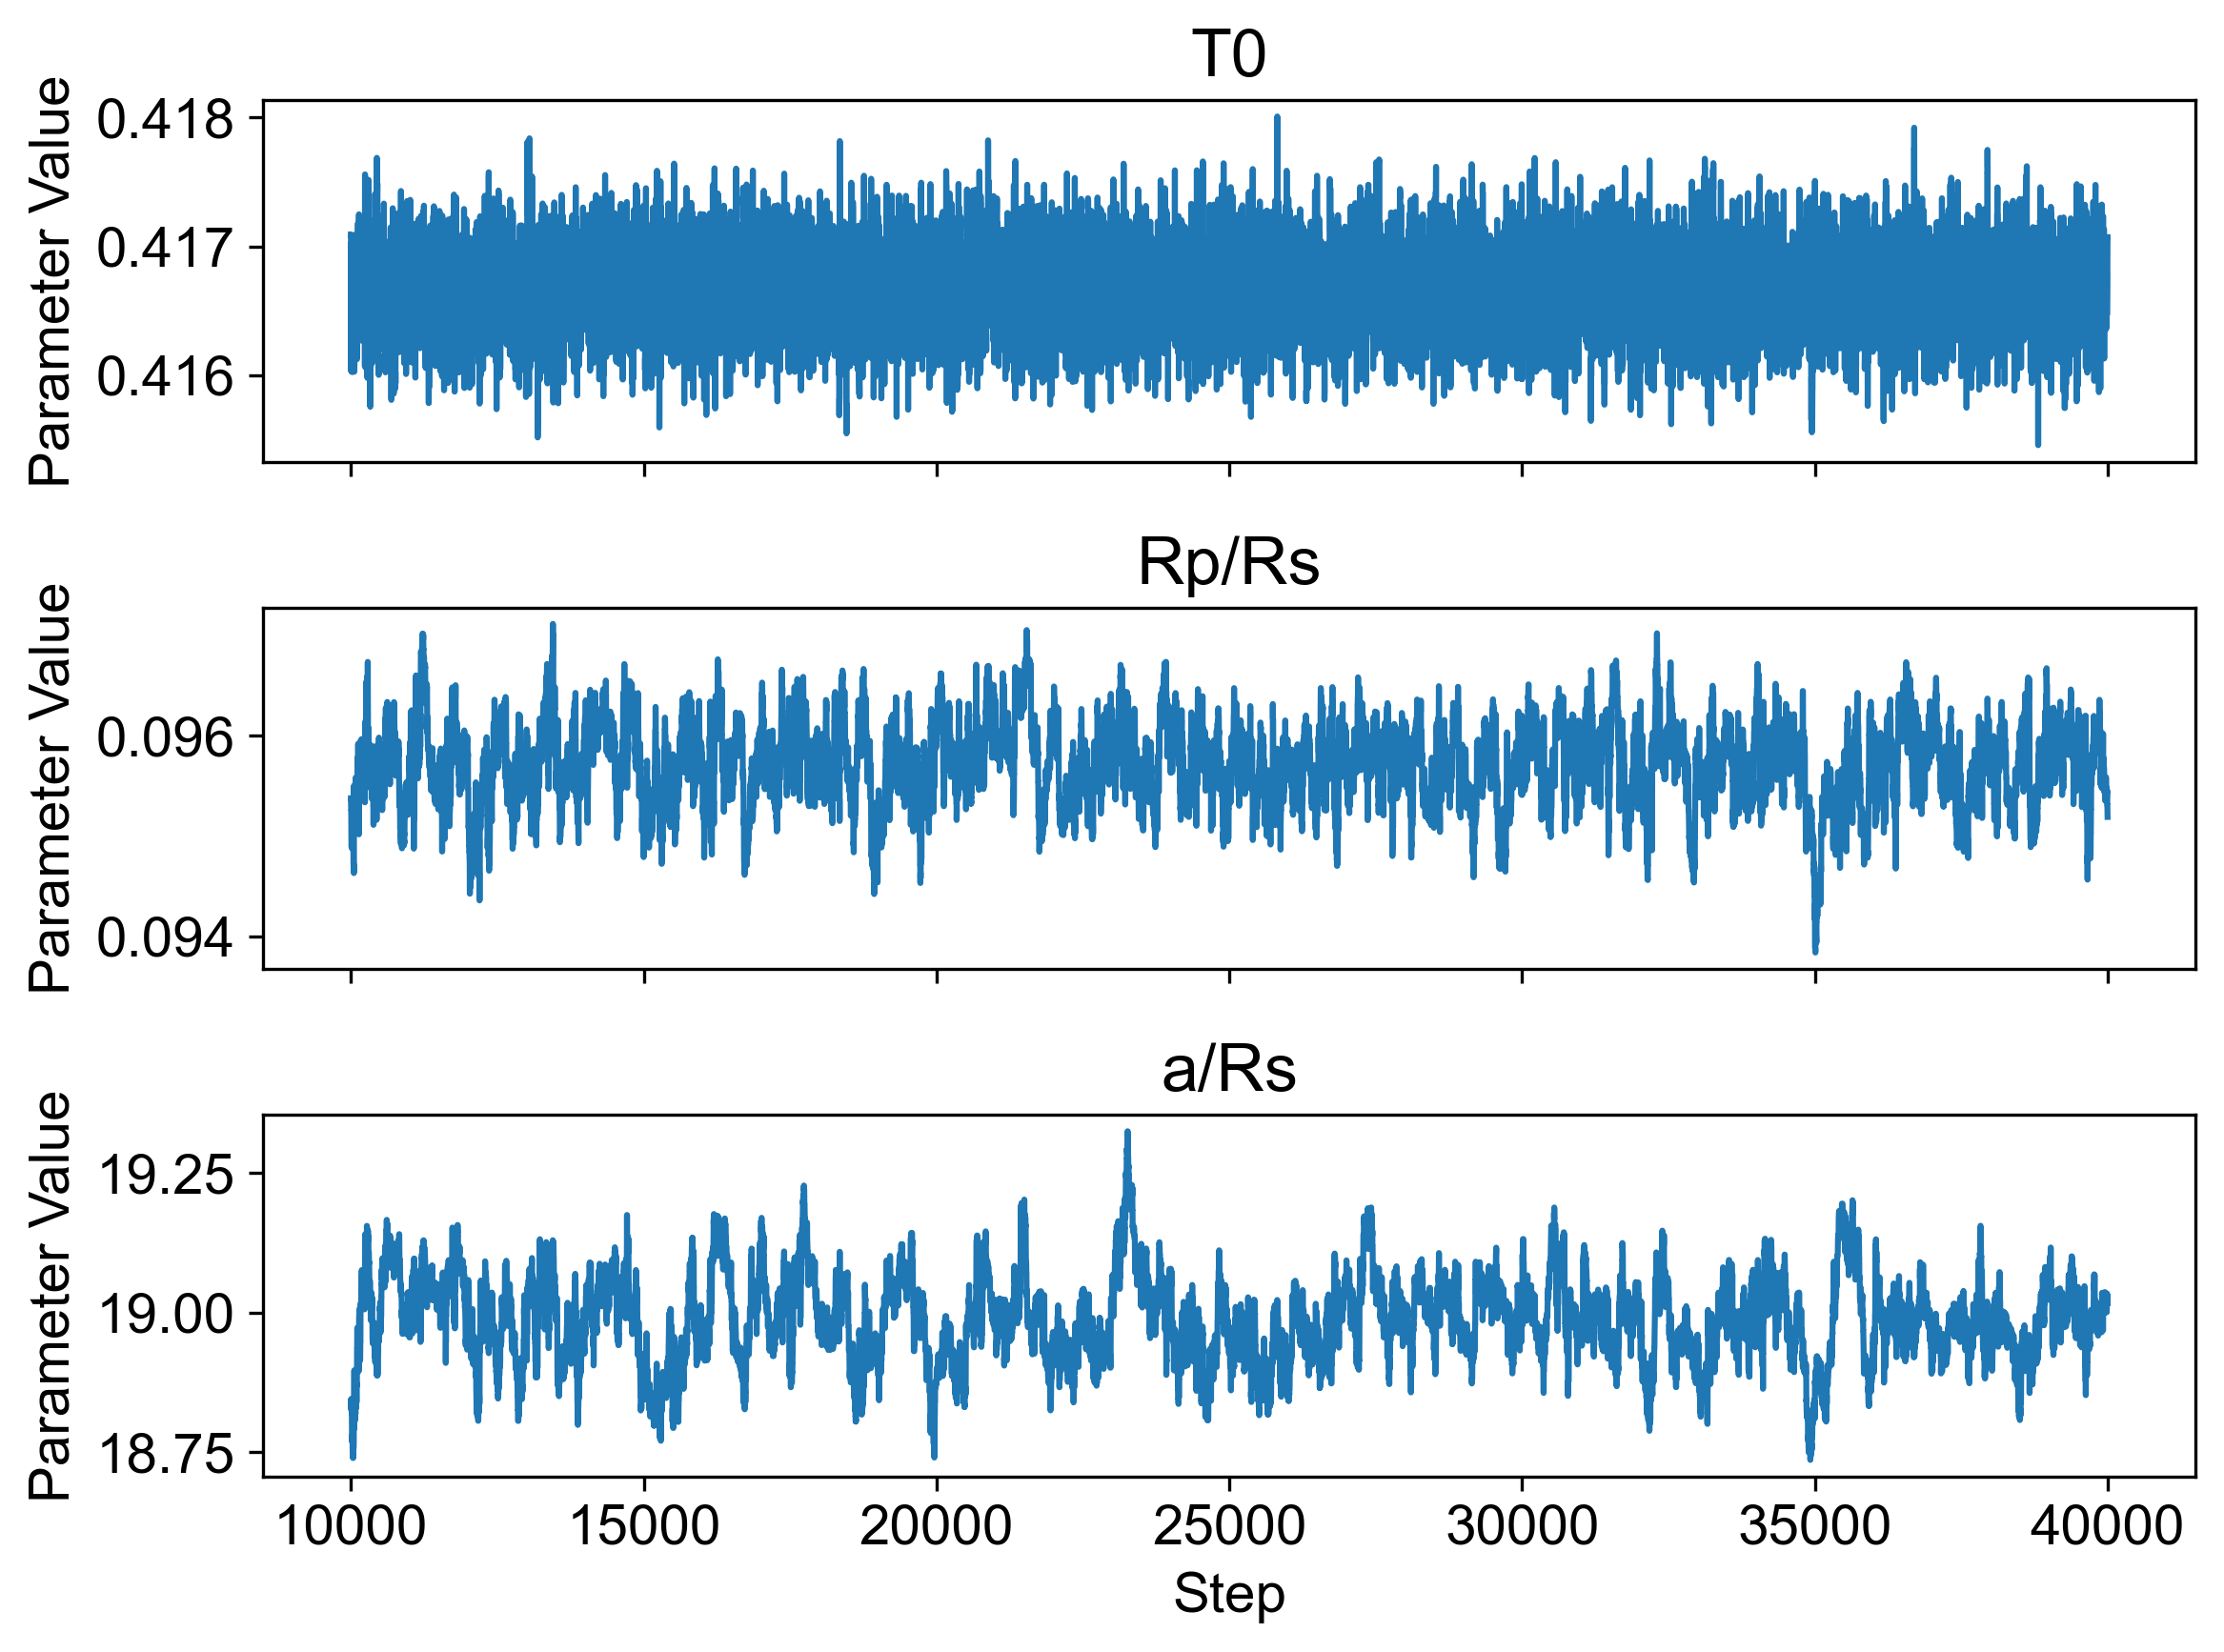

In [61]:
# Create a figure and subplots stacked vertically
fig, axes = plt.subplots(n_params, 1, figsize=(8, 2 * n_params), sharex=True)

# Plot each parameter chain on its corresponding subplot
for i, ax in enumerate(axes):
    ax.plot(steps, chain[:, i])  # Plot for the i-th parameter
    ax.set_title(titles[i])
    ax.set_ylabel("Parameter Value")

# Label the x-axis only on the bottom plot
axes[-1].set_xlabel("Step")

# Adjust the layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()


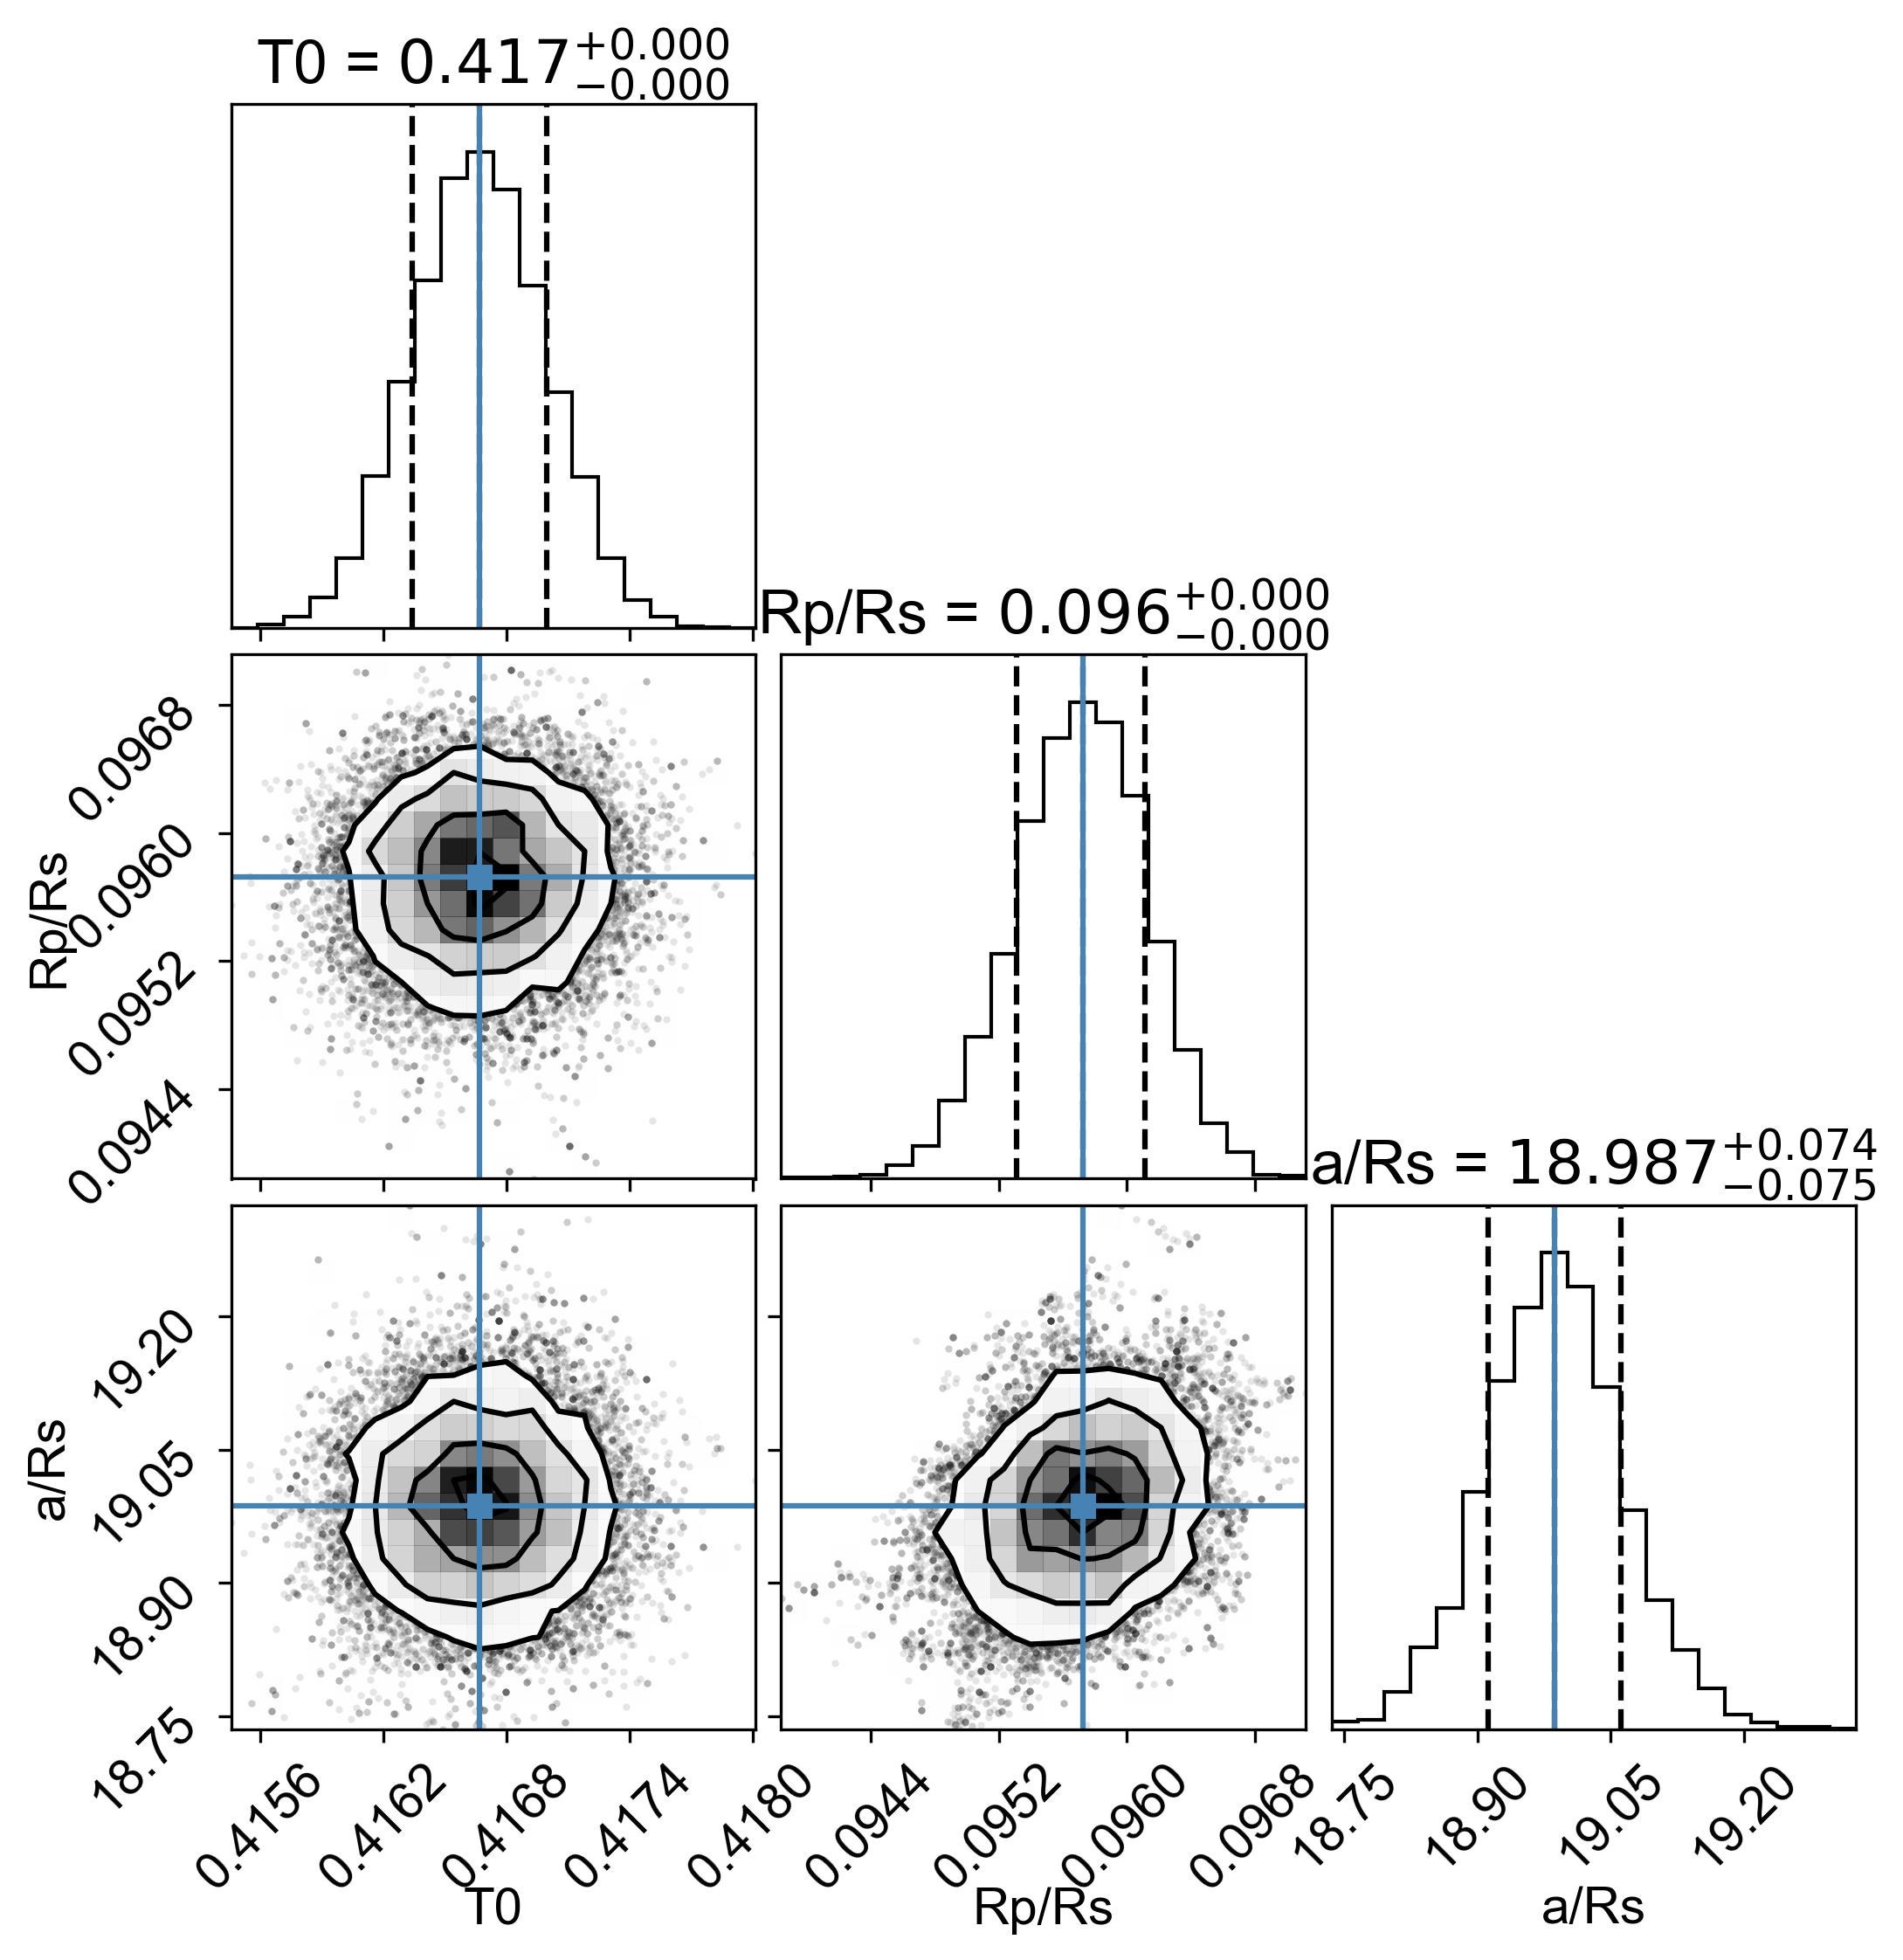

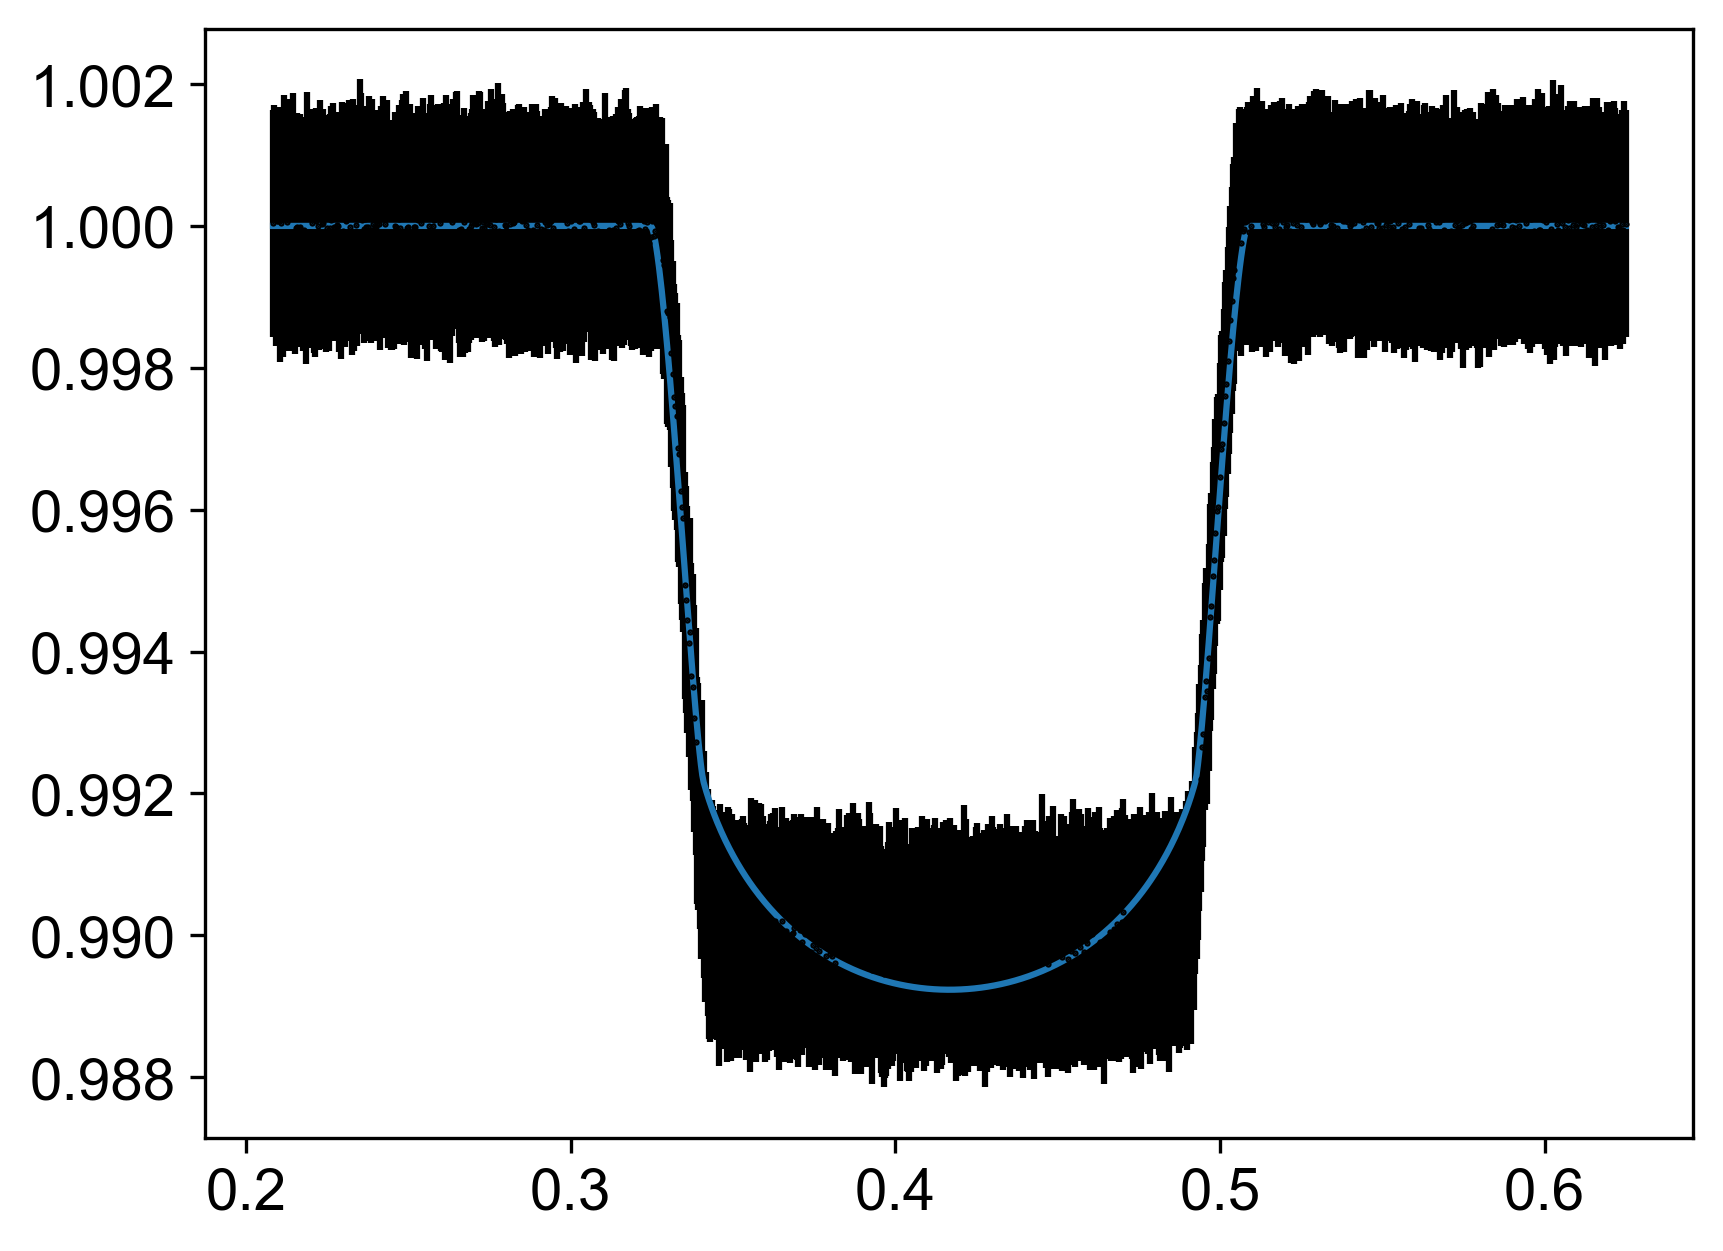

In [62]:
# Create a corner plot
fig = corner.corner(chain, labels=titles, truths=np.median(
    chain, axis=0), quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='.3f', )

# Show the plot
plt.show()

plt.errorbar(t, flux, errs, fmt='.', c='k', markersize=1)
plt.plot(t, get_transit(np.mean(chain, axis=0), t))
plt.show()

## oop! Fit with fixing limb darkening coeffs actually doesnt look as good ...